In [87]:
import os
import glob
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

plt.style.use('default')

BASE_PATH = 'dataset/graph_features'

Import dei file .pt contententi i dati PyG (subgraph 1-hop)

In [88]:
def load_pyg_data(fp) -> Data:
    """Carica un oggetto PyG Data da file .pt"""
    data = torch.load(fp)
    if not isinstance(data, Data):
        raise ValueError(f"File {fp} non contiene un oggetto torch_geometric.data.Data")
    return data

# Recupera tutti i file .pt
all_files = glob.glob(os.path.join(BASE_PATH, '*.pt'))
print(f"Trovati {len(all_files)} file .pt nel path {BASE_PATH}")


Trovati 2023 file .pt nel path dataset/graph_features


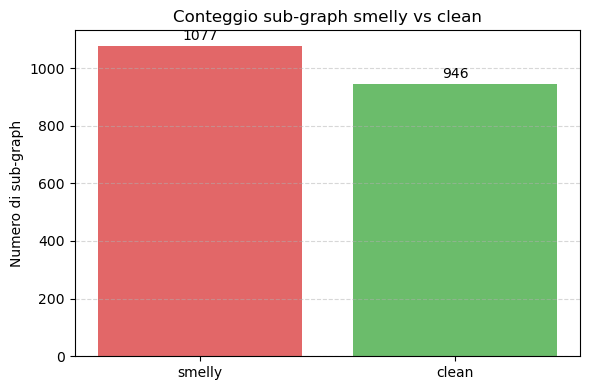

In [112]:
import matplotlib.pyplot as plt

# Conta smelly vs clean
counts = {'smelly': 0, 'clean': 0}
for fp in all_files:
    data = load_pyg_data(fp)
    if data.is_smelly.item() == 1:
        counts['smelly'] += 1
    else:
        counts['clean'] += 1

# Prepara dati
labels = list(counts.keys())
values = list(counts.values())

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=['tab:red','tab:green'], alpha=0.7)
plt.ylabel('Numero di sub-graph')
plt.title('Conteggio sub-graph smelly vs clean')

# Annotazioni
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h + max(values)*0.01,
             str(h), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Estrazione delle informazioni salienti e costruzione DataFrame

In [89]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx

records = []
alpha, beta, gamma = 0.4, 0.4, 0.2  # pesi che sommano a 1

# 1) Primo passaggio: calcola i valori raw di hub_score
for fp in all_files:
    data = load_pyg_data(fp)
    label = 'smelly' if data.is_smelly.item() == 1 else 'clean'
    center_node = getattr(data, 'center_node', None)

    # Estrai in/out degree
    edge_index = data.edge_index.numpy()
    idx = None
    if center_node is not None:
        orig_ids = getattr(data, 'original_node_ids', None)
        if orig_ids:
            try:
                idx = orig_ids.index(str(center_node))
            except ValueError:
                idx = None
        elif hasattr(data, 'center_node_idx'):
            idx = data.center_node_idx.item()

    if idx is not None:
        src, dst = edge_index
        fan_in  = float((dst == idx).sum())
        fan_out = float((src == idx).sum())
    else:
        fan_in = fan_out = np.nan

    # Calcola betweenness centrality
    G = to_networkx(data, node_attrs=None, edge_attrs=None)
    try:
        bc = nx.betweenness_centrality(G, normalized=True)
        bc_center = float(bc.get(center_node, 0.0))
    except Exception:
        bc_center = np.nan

    # Composizione raw
    raw_score = alpha * fan_in + beta * fan_out + gamma * bc_center

    records.append({
        'file': os.path.basename(fp),
        'label':    label,
        'fan_in':   fan_in,
        'fan_out':  fan_out,
        'betweenness_centrality': bc_center,
        'hub_score_raw':          raw_score,
        'n_nodes':  G.number_of_nodes(),
        'n_edges':  G.number_of_edges()
    })

df = pd.DataFrame(records)

# 2) Min–Max Normalization di hub_score_raw → hub_score_mm in [0,1]
min_raw = df['hub_score_raw'].min()
max_raw = df['hub_score_raw'].max()
df['hub_score_mm'] = (
    df['hub_score_raw'] - min_raw
) / (max_raw - min_raw + 1e-8)

# 3) (Opzionale) Sigmoid scaling per attenuare outlier
a = 0.1
b = df['hub_score_raw'].mean()
df['hub_score_sig'] = 1 / (1 + np.exp(-a*(df['hub_score_raw'] - b)))

# 4) Visualizza un’anteprima
print(df[['hub_score_raw','hub_score_mm','hub_score_sig']].describe())


       hub_score_raw  hub_score_mm  hub_score_sig
count    2023.000000   2023.000000    2023.000000
mean        8.169254      0.156965       0.483741
std         8.468487      0.190732       0.151677
min         1.200000      0.000000       0.332494
25%         3.600000      0.054054       0.387715
50%         5.200000      0.090090       0.426309
75%         8.800000      0.171171       0.515763
max        45.600000      1.000000       0.976867


Confronto delle metriche topologiche. Viene fatto il confronto del total degree sul nodo hub nelle sequenze smelly e clean.

In [ ]:
# 14. Plot evoluzione di hub_score per sequenze smelly→clean

def plot_hub_score_evolution(df_evo):
    """
    Per ogni (project, center) che contiene sia etichette 'smelly' che 'clean',
    disegna hub_score nel corso delle iterazioni.
    """
    # Raggruppa per hub
    groups = df_evo.groupby(['project','center'])
    count = 0

    for (proj, center), sub in groups:
        labs = set(sub['label'])
        # considera solo chi transita da smelly a clean
        if {'smelly','clean'}.issubset(labs):
            sub_sorted = sub.sort_values('iter')
            plt.figure(figsize=(6,4))
            # disegna la curva per smelly e clean
            for lbl, marker, color in zip(['smelly','clean'], ['o','s'], ['tab:red','tab:green']):
                part = sub_sorted[sub_sorted['label']==lbl]
                plt.plot(part['iter'], part['hub_score'],
                         marker=marker, linestyle='-',
                         label=lbl, color=color)
            plt.title(f"hub_score evolution — {proj}/{center}")
            plt.xlabel("Iterazione")
            plt.ylabel("Hub Score (total degree)")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
            count += 1

    if count == 0:
        print("⚠️  Non ci sono sequenze che transitano smelly→clean in df_evo.")

# Esempio di utilizzo
plot_hub_score_evolution(df_evo)


Text(0.5, 1.0, 'Matrice di correlazione')

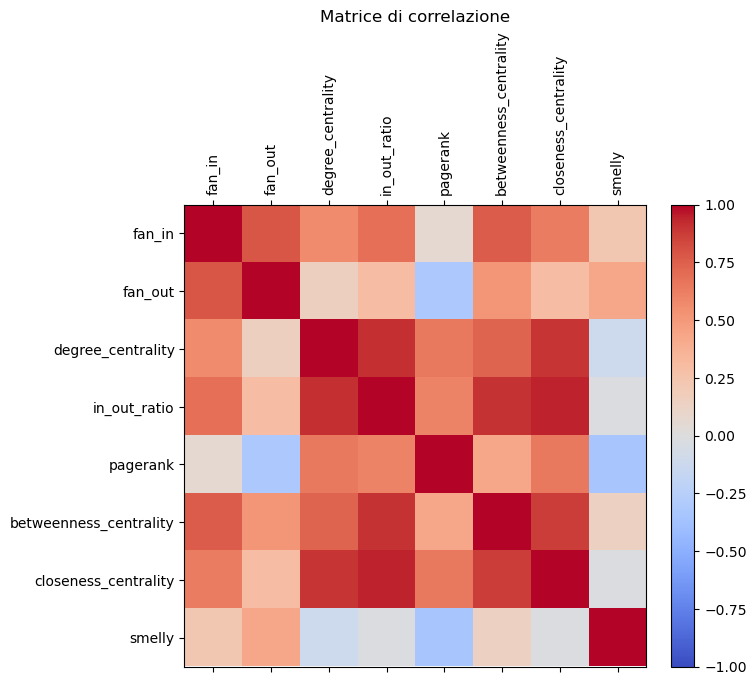

In [76]:
# 15. Matrice di correlazione fra metriche e label smelly/clean

import numpy as np
import matplotlib.pyplot as plt

# Definisci le metriche da includere
metrics = [
    'fan_in', 'fan_out', 'degree_centrality', 'in_out_ratio',
    'pagerank', 'betweenness_centrality', 'closeness_centrality'
]

# Costruisci DataFrame delle feature del nodo hub con label numerica
records = []
for fp in all_files:
    data = load_pyg_data(fp)
    # label: smelly=1, clean=0
    label = data.is_smelly.item()
    # estrai indice del nodo centrale
    idx = data.center_node_idx.item()
    # estrai vettore feature
    feat = data.x[idx].numpy()
    rec = {m: feat[i] for i, m in enumerate(metrics)}
    rec['smelly'] = label
    records.append(rec)

df_corr = pd.DataFrame(records)

# Calcola la matrice di correlazione
corr_mat = df_corr.corr()

# Visualizza con heatmap in matplotlib
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, fraction=0.046, pad=0.04)
ax.set_xticks(np.arange(len(corr_mat.columns)))
ax.set_yticks(np.arange(len(corr_mat.index)))
ax.set_xticklabels(corr_mat.columns, rotation=90)
ax.set_yticklabels(corr_mat.index)
ax.set_title('Matrice di correlazione')



/opt/anaconda3/envs/HLRefactorAssistant/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


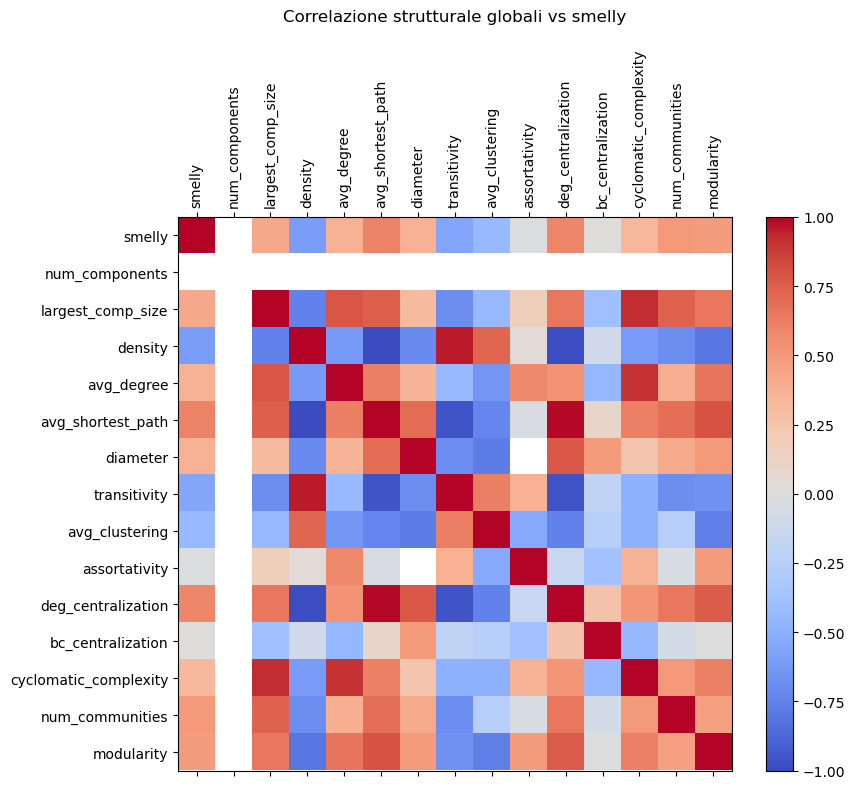

In [94]:
# 18. Correlazione fra metriche strutturali globali e target smelly/clean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

records = []

for fp in all_files:
    data = load_pyg_data(fp)
    label = data.is_smelly.item()  # 1=smelly, 0=clean
    G = to_networkx(data, node_attrs=None, edge_attrs=None)
    # Assicuriamoci di trattarlo come grafo non orientato
    if G.is_directed():
        G = G.to_undirected()

    n = G.number_of_nodes()
    m = G.number_of_edges()
    # 1) Connettività
    num_components = nx.number_connected_components(G)
    comps = list(nx.connected_components(G))
    largest_comp_size = max((len(c) for c in comps), default=0)
    # 2) Scala e densità
    density    = nx.density(G)
    avg_degree = sum(dict(G.degree()).values())/n if n>0 else np.nan
    # 3) Percorsi
    try:
        avg_spl = nx.average_shortest_path_length(G)
        diam    = nx.diameter(G)
    except nx.NetworkXError:
        avg_spl = diam = np.nan
    # 4) Clustering e transitivity
    trans       = nx.transitivity(G)
    avg_clust_g = nx.average_clustering(G)
    # 5) Assortatività
    assort = nx.degree_assortativity_coefficient(G)
    # 6) Centralizzazione globale
    degs    = dict(G.degree())
    max_deg = max(degs.values()) if degs else 0
    if n>2:
        deg_centralization = sum(max_deg - d for d in degs.values())/((n-1)*(n-2))
    else:
        deg_centralization = np.nan
    bc = nx.betweenness_centrality(G, normalized=True)
    max_bc = max(bc.values()) if bc else 0
    if n>2:
        bc_centralization = sum(max_bc - v for v in bc.values())/((n-1)*(n-2))
    else:
        bc_centralization = np.nan
    # 7) Cyclomatic complexity
    cyclomatic = m - n + num_components
    # 8) Community structure (Louvain-like greedy)
    try:
        comms      = list(community.greedy_modularity_communities(G))
        num_comms  = len(comms)
        modularity = community.modularity(G, comms)
    except Exception:
        num_comms = modularity = np.nan

    records.append({
        'smelly': label,
        'largest_comp_size':    largest_comp_size,
        'density':              density,
        'avg_degree':           avg_degree,
        'avg_shortest_path':    avg_spl,
        'diameter':             diam,
        'transitivity':         trans,
        'avg_clustering':       avg_clust_g,
        'assortativity':        assort,
        'deg_centralization':   deg_centralization,
        'bc_centralization':    bc_centralization,
        'cyclomatic_complexity': cyclomatic,
        'num_communities':      num_comms,
        'modularity':           modularity
    })

# Costruisci DataFrame e calcola correlazioni
df_struct = pd.DataFrame(records)
corr = df_struct.corr()

# Visualizza con heatmap
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, fraction=0.046, pad=0.04)
labels = corr.columns
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
ax.set_title('Correlazione strutturale globali vs smelly', pad=20)
plt.tight_layout()
plt.show()


Ricavate le metriche strutturali che risultano essere fra le più correllate con la classe smell (Degree centralization, Cyclomatic complexity, Density), calcoliamo un hub_score composito che le combina in modo da poterlo usare come feature per il modello RL. Sono state tutte e 3 normalizzate in [0,1] e poi combinate con media semplice. La densità è stata invertita perché bassa densità = più smell.

Sono state scelte queste metriche perché risultate più correlate con la classe smelly e significative per la struttura del grafo per l'identificazione di smell. Non escludo che possa essere estendibile.

In [96]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

eps = 1e-8
records = []

for fp in all_files:
    data = load_pyg_data(fp)
    if not isinstance(data, Data):
        continue
    label = data.is_smelly.item()  # 1 smelly, 0 clean

    # Ricostruisci grafo undirected per le metriche
    G = to_networkx(data, node_attrs=None, edge_attrs=None)
    if G.is_directed():
        G = G.to_undirected()

    n = G.number_of_nodes()
    m = G.number_of_edges()
    # 1) degree centralization
    degs    = dict(G.degree())
    max_deg = max(degs.values()) if degs else 0
    deg_cent = (sum(max_deg - d for d in degs.values())
                / ((n-1)*(n-2) + eps)) if n>2 else 0.0

    # 2) cyclomatic complexity
    num_comp     = nx.number_connected_components(G)
    cyclomatic   = m - n + num_comp

    # 3) density
    density      = nx.density(G)

    records.append({
        'file': os.path.basename(fp),
        'label': label,
        'deg_centralization':   deg_cent,
        'cyclomatic_complexity': cyclomatic,
        'density':               density
    })

# 4) Costruisci DataFrame
df = pd.DataFrame(records)

# 5) Normalizza in [0,1] (min–max)
for col in ['deg_centralization', 'cyclomatic_complexity', 'density']:
    mn, mx = df[col].min(), df[col].max()
    df[f'{col}_norm'] = (df[col] - mn) / (mx - mn + eps)

# Inverti density perché bassa densità = più smell
df['inv_density_norm'] = 1 - df['density_norm']

# 6) Calcola hub_score composito
df['hub_score'] = df[[
    'deg_centralization_norm',
    'cyclomatic_complexity_norm',
    'inv_density_norm'
]].mean(axis=1)

# 7) Anteprima
display(df[[
    'file','label',
    'deg_centralization','cyclomatic_complexity','density',
    'deg_centralization_norm','cyclomatic_complexity_norm','density_norm','inv_density_norm',
    'hub_score'
]].head())


,file,label,deg_centralization,cyclomatic_complexity,density,deg_centralization_norm,cyclomatic_complexity_norm,density_norm,inv_density_norm,hub_score
0,opennlp-hl-23-24-25_762_0314_2012_7d91ff2e.pt,0,0.619048,8,0.535714,0.679482,0.025180,0.474463,0.525537,0.410066
1,commons-lang-hl-23-24-25_861_0146_7588_7e808a8...,1,0.644444,16,0.472727,0.707359,0.053957,0.403166,0.596834,0.452716
2,commons-lang-hl-23-24-25_1766_0114_7664_7d8433...,0,0.428571,12,0.678571,0.470411,0.039568,0.636167,0.363833,0.291271
3,commons-lang-hl-23-24-25_265_0536_8429_7d419b9...,0,0.464286,15,0.638889,0.509612,0.050360,0.591249,0.408751,0.322908
4,opennlp-hl-23-24-25_4665_0300_2065_6fde608c.pt,1,0.647368,67,0.414286,0.710568,0.237410,0.337015,0.662985,0.536988


Label uniche: [0 1]
Conteggio per label:
 label
1    1077
0     946
Name: count, dtype: int64
hub_score stats:
 count    2.023000e+03
mean     4.256284e-01
std      2.272516e-01
min      3.773087e-09
25%      3.229075e-01
50%      4.221892e-01
75%      5.740909e-01
max      8.872902e-01
Name: hub_score, dtype: float64 



/var/folders/09/nmlxt4pj7lj5bkszcq0frhwm0000gn/T/ipykernel_2292/3845725787.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([smelly_scores, clean_scores], labels=['smelly','clean'], notch=True)


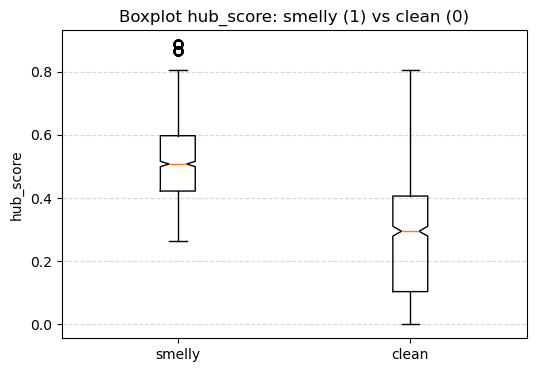

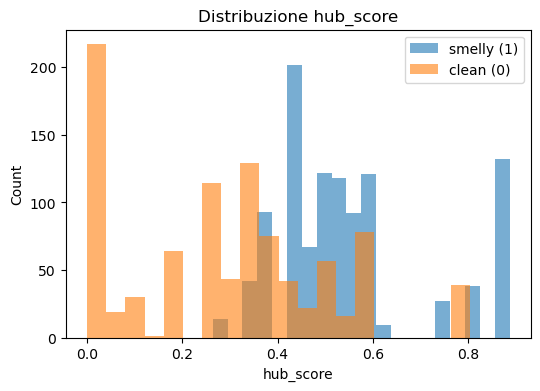

T-test:  t = 30.31, p = 0.0000
KS-test: D = 0.63, p = 0.0000
AUC = 0.840


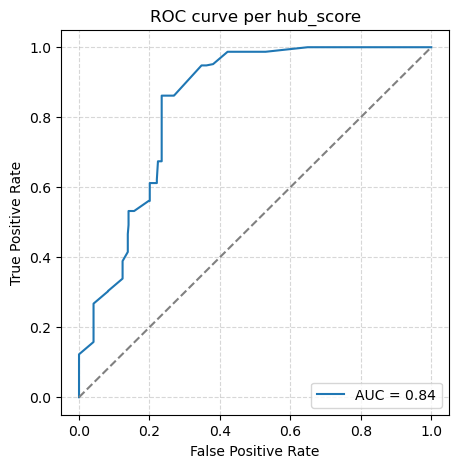

In [100]:
# Assicuriamoci di avere inline plotting
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp
from sklearn.metrics import roc_curve, auc

# Debug rapido
print("Label uniche:", np.unique(df['label']))
print("Conteggio per label:\n", df['label'].value_counts())
print("hub_score stats:\n", df['hub_score'].describe(), "\n")

# Estrai le serie corrette
smelly_scores = df.loc[df['label']==1, 'hub_score']
clean_scores  = df.loc[df['label']==0, 'hub_score']
y_true        = df['label'].values
y_score       = df['hub_score'].values

# Avvisi se seriali vuote o costanti
if smelly_scores.empty or clean_scores.empty:
    print("⚠️ Una delle due serie è vuota: verifica i valori in 'label'.")
if df['hub_score'].nunique() <= 1:
    print("⚠️ hub_score è quasi costante, non ci sono variazioni da plottare.")

# 1) Boxplot
plt.figure(figsize=(6,4))
plt.boxplot([smelly_scores, clean_scores], labels=['smelly','clean'], notch=True)
plt.ylabel('hub_score')
plt.title('Boxplot hub_score: smelly (1) vs clean (0)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 2) Istogrammi sovrapposti
plt.figure(figsize=(6,4))
plt.hist(smelly_scores, bins=20, alpha=0.6, label='smelly (1)')
plt.hist(clean_scores,  bins=20, alpha=0.6, label='clean (0)')
plt.xlabel('hub_score')
plt.ylabel('Count')
plt.title('Distribuzione hub_score')
plt.legend()
plt.show()

# 3) Test statistici
t_stat, p_t   = ttest_ind(smelly_scores, clean_scores, equal_var=False)
ks_stat, p_ks = ks_2samp(smelly_scores, clean_scores)
print(f"T-test:  t = {t_stat:.2f}, p = {p_t:.4f}")
print(f"KS-test: D = {ks_stat:.2f}, p = {p_ks:.4f}")

# 4) Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc     = auc(fpr, tpr)
print(f"AUC = {roc_auc:.3f}")

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve per hub_score')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Modello di Regressione Logistica per predire smelly/clean

Il seguente modello è stato utilizzato per predire se una sequenza è smelly o clean basandosi sul valore di hub_score. In questo modo posso intuire quanto effettivamente hub_score riesca a discriminare le due classi e quindi se può essere considerato buono per la reward del modello RL.

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

In [107]:
X = df[['hub_score']].values     # shape: [n_samples, 1]
y = df['label'].values           # 0 = clean, 1 = smelly

In [108]:
clf = LogisticRegression(solver='liblinear')
cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [109]:
y_pred  = cross_val_predict(clf, X, y, cv=cv)
y_proba = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')[:, 1]

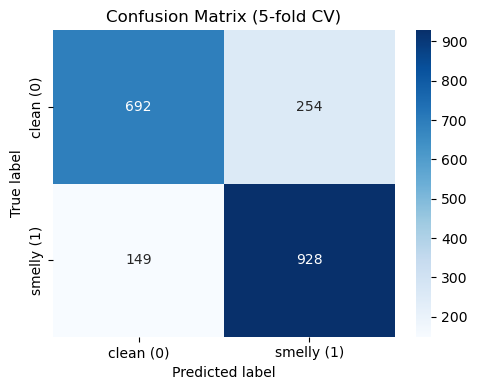


Classification Report:
               precision    recall  f1-score   support

       clean       0.82      0.73      0.77       946
      smelly       0.79      0.86      0.82      1077

    accuracy                           0.80      2023
   macro avg       0.80      0.80      0.80      2023
weighted avg       0.80      0.80      0.80      2023



In [110]:
cm = confusion_matrix(y, y_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['clean (0)','smelly (1)'],
            yticklabels=['clean (0)','smelly (1)'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (5-fold CV)')
plt.tight_layout()
plt.show()

print("\nClassification Report:\n",
      classification_report(y, y_pred, target_names=['clean','smelly']))

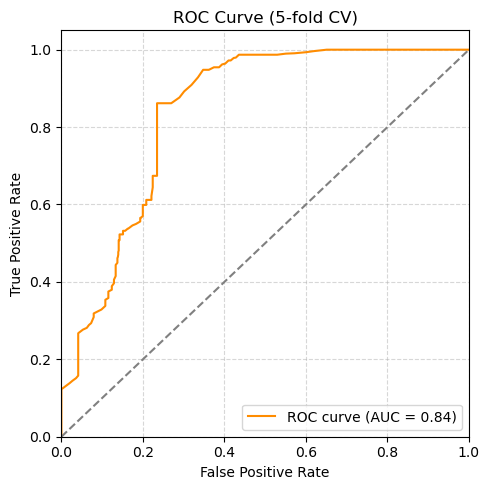

In [111]:
fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (5-fold CV)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()